In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import os
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from utils import *
from model import *

# Specify dataset path and device configuration
dataset_path = r"ADBench_datasets/6_cardio.npz"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 4.1: Load and preprocess data
X_all, y_all = load_adbench_data(dataset_path) # new preprocessing
input_dim = X_all.shape[1]

# Standardize features using StandardScaler
scaler = StandardScaler()
X_all = torch.tensor(scaler.fit_transform(X_all)).float()

# Split data into train and test sets
D_train_np, D_test_np, y_train_np, y_test_np = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=0.6, random_state=42, stratify=y_all
)
D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)

# Create DataLoader for training Beta-CVAE
train_dataset = TensorDataset(D_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Step 4.2: Initialize Beta-CVAE model
# Increase beta (e.g., beta=4.0) to emphasize KL divergence, encouraging more diverse latent space
beta_cvae = BetaCVAE(input_dim=input_dim, hidden_dim=512, latent_dim=64, beta=1.0).to(device)

# Train Beta-CVAE model
optimizer_cvae = Adam(beta_cvae.parameters(), lr=1e-4)
num_epochs_cvae = 150
for epoch in range(num_epochs_cvae):
    loss_cvae = train_beta_cvae(beta_cvae, train_loader, optimizer_cvae, device)
    if (epoch + 1) % 2 == 0:
        print(f"[Beta-CVAE] Epoch {epoch+1}/{num_epochs_cvae}, loss={loss_cvae:.2f}")

# Step 4.3: Generate synthetic data to maximize diversity
# Instead of sampling z ~ Normal(0,1), use z ~ Uniform([-2,2]) to increase coverage and encourage diversity
beta_cvae.eval()

# Separate minority and majority classes
minority_mask = (y_train == 1)
X_minority = D_train[minority_mask]
majority_mask = (y_train == 0)
X_majority = D_train[majority_mask]

# Calculate the number of synthetic samples to generate
num_generate = len(X_majority) - len(X_minority)

with torch.no_grad():
    # Generate latent variables uniformly within [-2,2]
    z_uniform = (torch.rand(num_generate, beta_cvae.latent_dim) * 4.0) - 2.0
    z_uniform = z_uniform.to(device)

    # Assign synthetic labels (e.g., oversample minority class with y=1)
    y_synthetic_c = torch.full((num_generate, 1), 0.9, device=device)

    # Decode synthetic data
    X_synthetic = beta_cvae.decode(z_uniform, y_synthetic_c)
    X_synthetic = X_synthetic.cpu()

# Create labels for synthetic samples
y_synthetic_labels = torch.ones(num_generate)

# Combine synthetic data with original training data
D_train_final = torch.cat([D_train, X_synthetic], dim=0)
y_train_final = torch.cat([y_train, y_synthetic_labels], dim=0)

# Step 4.4: Train TransformerDetector on the augmented dataset
train_dataset_final = TensorDataset(D_train_final, y_train_final)
test_dataset = TensorDataset(D_test, y_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

print("After oversampling with Beta-CVAE:")
unique, counts = np.unique(y_train_final.numpy(), return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))

# Initialize Transformer Detector model
model = TransformerDetector(input_size=input_dim).to(device)
optimizer_tf = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

# Train the Transformer Detector model
num_epochs_tf = 50
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader_final, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch+1}/{num_epochs_tf}, Loss={train_loss:.4f}")
    print("-" * 40)

# Ensure the directory for saving models exists
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

# Save the trained Beta-CVAE model
vae_path = os.path.join(save_dir, "beta_cvae.pth")
torch.save(beta_cvae.state_dict(), vae_path)
print(f"Beta-CVAE model saved to: {vae_path}")

# Save the trained TransformerDetector model
detector_path = os.path.join(save_dir, "transformer_detector.pth")
torch.save(model.state_dict(), detector_path)
print(f"TransformerDetector model saved to: {detector_path}")


[Beta-CVAE] Epoch 2/150, loss=1285.01
[Beta-CVAE] Epoch 4/150, loss=1277.05
[Beta-CVAE] Epoch 6/150, loss=1267.29
[Beta-CVAE] Epoch 8/150, loss=1236.02
[Beta-CVAE] Epoch 10/150, loss=1171.67
[Beta-CVAE] Epoch 12/150, loss=1073.04
[Beta-CVAE] Epoch 14/150, loss=1021.88
[Beta-CVAE] Epoch 16/150, loss=1010.67
[Beta-CVAE] Epoch 18/150, loss=995.68
[Beta-CVAE] Epoch 20/150, loss=981.79
[Beta-CVAE] Epoch 22/150, loss=978.88
[Beta-CVAE] Epoch 24/150, loss=951.28
[Beta-CVAE] Epoch 26/150, loss=953.21
[Beta-CVAE] Epoch 28/150, loss=955.91
[Beta-CVAE] Epoch 30/150, loss=924.41
[Beta-CVAE] Epoch 32/150, loss=930.67
[Beta-CVAE] Epoch 34/150, loss=918.81
[Beta-CVAE] Epoch 36/150, loss=909.92
[Beta-CVAE] Epoch 38/150, loss=898.35
[Beta-CVAE] Epoch 40/150, loss=891.01
[Beta-CVAE] Epoch 42/150, loss=880.74
[Beta-CVAE] Epoch 44/150, loss=897.23
[Beta-CVAE] Epoch 46/150, loss=872.27
[Beta-CVAE] Epoch 48/150, loss=867.88
[Beta-CVAE] Epoch 50/150, loss=866.02
[Beta-CVAE] Epoch 52/150, loss=860.41
[Beta-CV

torch.Size([732, 21])
Models loaded successfully.
===== EPISODE 1/100 =====
Phân phối lớp trong tập train: {0.0: 662, 1.0: 70}
===== Generated Data 0 =====
Deceiving Detector Reward: 1.0001 Diversity reward: 0.9214 Sample reward: 0.9021
Phân phối lớp trong tập train: {0.0: 662, 1.0: 70}
===== Generated Data 1 =====
Deceiving Detector Reward: 1.0002 Diversity reward: 1.7838 Sample reward: 0.9471
Phân phối lớp trong tập train: {0.0: 662, 1.0: 70}
===== Generated Data 2 =====
Deceiving Detector Reward: 1.0002 Diversity reward: 23.2842 Sample reward: 0.9959
Phân phối lớp trong tập train: {0.0: 662, 1.0: 70}
===== Generated Data 3 =====
Deceiving Detector Reward: 1.0001 Diversity reward: 1.9279 Sample reward: 0.9507
Phân phối lớp trong tập train: {0.0: 662, 1.0: 70}
===== Generated Data 4 =====
Deceiving Detector Reward: 1.0001 Diversity reward: 1.6290 Sample reward: 0.9422
Phân phối lớp trong tập train: {0.0: 662, 1.0: 70}
===== Generated Data 5 =====
Deceiving Detector Reward: 1.0002 Dive

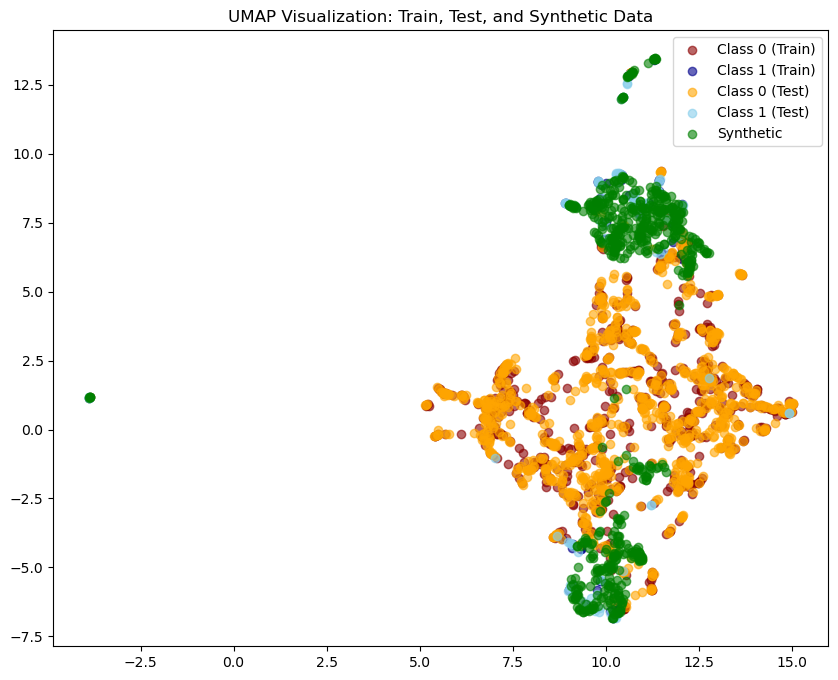

Sau khi oversampling bằng VAE:
Phân phối lớp trong tập train: {0.0: 662, 1.0: 70}
[Transformer] Epoch 1/200, Loss=0.3319
Test set evaluation:
              precision    recall  f1-score   support

     Class 0       0.96      0.99      0.97       993
     Class 1       0.88      0.60      0.72       106

    accuracy                           0.95      1099
   macro avg       0.92      0.80      0.84      1099
weighted avg       0.95      0.95      0.95      1099

AUC-ROC: 0.9661
----------------------------------------
[Transformer] Epoch 2/200, Loss=0.1221
Test set evaluation:
              precision    recall  f1-score   support

     Class 0       0.99      0.96      0.98       993
     Class 1       0.73      0.91      0.81       106

    accuracy                           0.96      1099
   macro avg       0.86      0.93      0.89      1099
weighted avg       0.96      0.96      0.96      1099

AUC-ROC: 0.9897
----------------------------------------
[Transformer] Epoch 3/200, Los

In [3]:
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler
from utils import *
from model import *
import umap

# Ví dụ đường dẫn
dataset_path = r"ADBench_datasets/6_cardio.npz"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Lưu Beta-CVAE
# Đảm bảo thư mục lưu trữ tồn tại
save_dir = "./saved_models"
vae_path = os.path.join(save_dir, "beta_cvae.pth")
detector_path = os.path.join(save_dir, "transformer_detector.pth")

# 4.1: Load Data
X_all, y_all = load_adbench_data(dataset_path) # this loads data from the specified path woith preprocessing
input_dim = X_all.shape[1]
scaler = StandardScaler()
X_all = torch.tensor(scaler.fit_transform(X_all)).float()

# Chia train/test
D_train_np, D_test_np, y_train_np, y_test_np = train_test_split(
    X_all.numpy(), y_all.numpy(), test_size=0.6, random_state=42, stratify=y_all
)
D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)
print(D_train.shape)
# DataLoader cho Beta-CVAE
train_dataset = TensorDataset(D_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Khởi tạo mô hình cùng cấu hình ban đầu
loaded_beta_cvae = BetaCVAE(input_dim=input_dim, hidden_dim=512, latent_dim=64, beta=1.0).to(device)
loaded_detector_model = TransformerDetector(input_size=input_dim).to(device)

# Load trạng thái mô hình đã lưu
# Chỉ load trọng số
loaded_beta_cvae.load_state_dict(torch.load(vae_path, weights_only=True))
loaded_detector_model.load_state_dict(torch.load(detector_path, weights_only=True))

# Đặt mô hình về chế độ eval (nếu chỉ sử dụng inference)
loaded_beta_cvae.eval()
loaded_detector_model.eval()

print("Models loaded successfully.")


num_episodes = 100
num_gen_data = 50
batch_size = 128
new_detector = TransformerDetector(input_size=input_dim).to(device)
optimizer_cvae = Adam(loaded_beta_cvae.parameters(), lr=1e-4)
optimizer_detector = Adam(new_detector.parameters(), lr=1e-4)
criterion = nn.BCELoss()
# File log
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
beta_cvae_log = os.path.join(log_dir, "beta_cvae.log")
detector_log = os.path.join(log_dir, "detector.log")
adversarial_log = os.path.join(log_dir, "adversarial_samples.log")
synthetic_data = []
start_idx = 0  # Vị trí bắt đầu ban đầu

for ep in range(num_episodes):
    # Lấy mask cho class 1
    class1_mask = (y_train == 1)  # Boolean tensor: True nếu y_train[i] == 1
    class0_mask = (y_train == 0)  # Boolean tensor: True nếu y_train[i] == 0

    # Đếm số lượng phần tử của mỗi class
    num_class1 = class1_mask.sum().item()
    num_class0 = class0_mask.sum().item()

    # Kiểm tra nếu số lượng class 1 vượt quá class 0, thoát vòng lặp
    if num_class1 > num_class0:
        print(f"Break at Episode {ep + 1}: Class 1 ({num_class1}) exceeds Class 0 ({num_class0}).")
        break
    # Lọc các mẫu thuộc class 1 từ D_train
    # Lọc các mẫu thuộc class 1 từ D_train
    D_train_grow_tensor = D_train[class1_mask]  # Tensor chứa tất cả các mẫu class 1
    # Chuyển mỗi hàng thành một tensor và lưu vào list
    D_train_grow = [row for row in D_train_grow_tensor]
    print(f"===== EPISODE {ep + 1}/{num_episodes} =====")

    # Train Beta-CVAE
    train_dataset = TensorDataset(D_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    num_epochs_cvae = 10
    for epoch in range(num_epochs_cvae):
        loss_cvae = train_beta_cvae(loaded_beta_cvae, train_loader, optimizer_cvae, device)
        log_to_file(beta_cvae_log, f"Epoch {epoch + 1}/{num_epochs_cvae}, Loss: {loss_cvae:.4f}")

    detector_epochs = 5
    train_dataset_detector = TensorDataset(D_train, y_train)
    train_loader_detector = DataLoader(train_dataset_detector, batch_size=batch_size, shuffle=True)
    for det_epoch in range(detector_epochs):
        detector_loss = train_detector(new_detector, train_loader_detector, optimizer_detector, criterion, device)
        # Giả sử y_train có dạng 0/1
    # print(f"===== Evaluate in Testing set =====")
    # evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5)
    # Generate Adversarial Samples
    idx_class1 = (y_train == 1).nonzero(as_tuple=True)[0]
    new_samples, new_labels = [], []
    # Lấy các index từ idx_class1, xử lý wrap-around nếu cần
    end_idx = start_idx + num_gen_data
    indices = idx_class1[start_idx:end_idx]

    # Nếu vượt quá độ dài của idx_class1, quay lại từ đầu
    if end_idx > len(idx_class1):
        indices += idx_class1[:end_idx - len(idx_class1)]

    # Cập nhật vị trí bắt đầu cho vòng lặp tiếp theo
    start_idx = end_idx % len(idx_class1)
    for syn_data in range(num_gen_data):
        unique, counts = np.unique(y_train.numpy(), return_counts=True)
        print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))
        print("===== Generated Data {} =====".format(syn_data))
        random_idx = random.choice(idx_class1)
        x_orig = D_train[random_idx]
        x_adv = One_Step_To_Feasible_Action(
            beta_cvae=loaded_beta_cvae,
            detector=loaded_detector_model,
            x_orig=x_orig,
            device=device,
            previously_generated=D_train_grow,
            alpha=1.0,
            lambda_div=0.1,
            lr=0.01,
            steps=20,
            log_file=adversarial_log,
        )
        new_samples.append(x_adv.unsqueeze(0))
        new_labels.append(torch.tensor([1]))
        synthetic_data.append(x_adv)
    new_samples = torch.cat(new_samples, dim=0)
    new_labels = torch.cat(new_labels, dim=0)
    D_train = torch.cat([D_train, new_samples], dim=0)
    y_train = torch.cat([y_train, new_labels], dim=0)

#___________________________________________________________
# 4.4: Visualize Generated Data



plt.style.use('default')  # Đảm bảo sử dụng style mặc định

D_train = torch.tensor(D_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
D_test  = torch.tensor(D_test_np,  dtype=torch.float32)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32)

X_synthetic = np.asarray(synthetic_data)
X_synthetic = torch.tensor(X_synthetic,  dtype=torch.float32)

# 1) Gộp dữ liệu
X_plot = torch.cat([D_train, D_test, X_synthetic], dim=0).numpy()

# Tạo nhãn:
# - Phần đầu: y_train (0 hoặc 1)
# - Tiếp theo: y_test (0 hoặc 1)
# - Cuối cùng: synthetic (2)
N_train = len(D_train)
N_test = len(D_test)
N_synthetic = len(X_synthetic)
y_plot = np.concatenate([
    y_train.numpy(),            # Nhãn train
    y_test.numpy(),             # Nhãn test
    np.full((N_synthetic,), 2)  # Nhãn synthetic
], axis=0)

# 2) Chuẩn hoá dữ liệu (nếu cần)
scaler = StandardScaler()
X_plot_scaled = scaler.fit_transform(X_plot)

# 3) Tính UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)

X_embedded = reducer.fit_transform(X_plot_scaled)
# X_embedded.shape = (N_train + N_test + N_synthetic, 2)

# 4) Vẽ
plt.figure(figsize=(10, 8), facecolor='white')  # Đặt nền trắng

# Train Class 0 -> đỏ
idx0_train = (y_plot[:N_train] == 0)
plt.scatter(X_embedded[:N_train][idx0_train, 0], X_embedded[:N_train][idx0_train, 1],
            c='darkred', alpha=0.6, label='Class 0 (Train)')

# Train Class 1 -> xanh dương
idx1_train = (y_plot[:N_train] == 1)
plt.scatter(X_embedded[:N_train][idx1_train, 0], X_embedded[:N_train][idx1_train, 1],
            c='darkblue', alpha=0.6, label='Class 1 (Train)')

# Test Class 0 -> cam
idx0_test = (y_plot[N_train:N_train + N_test] == 0)
plt.scatter(X_embedded[N_train:N_train + N_test][idx0_test, 0],
            X_embedded[N_train:N_train + N_test][idx0_test, 1],
            c='orange', alpha=0.6, label='Class 0 (Test)')

# Test Class 1 -> xanh nhạt
idx1_test = (y_plot[N_train:N_train + N_test] == 1)
plt.scatter(X_embedded[N_train:N_train + N_test][idx1_test, 0],
            X_embedded[N_train:N_train + N_test][idx1_test, 1],
            c='skyblue', alpha=0.6, label='Class 1 (Test)')

# Synthetic Data -> xanh lá
idx_syn = (y_plot[N_train + N_test:] == 2)
plt.scatter(X_embedded[N_train + N_test:][idx_syn, 0],
            X_embedded[N_train + N_test:][idx_syn, 1],
            c='green', alpha=0.6, label='Synthetic')

plt.title("UMAP Visualization: Train, Test, and Synthetic Data")
plt.legend()
plt.show()

#______________________________________________________
  # 4.4: Train mô hình TransformerDetector
train_dataset_final = TensorDataset(D_train, y_train)
test_dataset = TensorDataset(D_test, y_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
print("Sau khi oversampling bằng VAE:")
unique, counts = np.unique(y_train.numpy(), return_counts=True)
print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))

# model = MixtureOfExperts(input_size=input_dim, num_experts= 10)
model = TransformerDetector(input_size=input_dim).to(device)
optimizer_tf = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
num_epochs_tf = 200
score_total=0
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader_final, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch + 1}/{num_epochs_tf}, Loss={train_loss:.4f}")

    # Đánh giá
    print("Test set evaluation:")
    r, score = evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.4)
    print("-" * 40) 

In [111]:
x_orig = X_all[100].to(device).unsqueeze(0)
print(x_orig.shape)  # Reshape to batch format (1, d)
y_class1 = torch.full((1, 1), 0, device=device)  # Target class label (e.g., 0.8)

    # Encode input data into latent space
with torch.no_grad():
        mean, logvar = beta_cvae.encode(x_orig, y_class1)
        z = beta_cvae.reparameterize(mean, logvar).detach().clone()



        # Decode latent variable back to data space
x_synthetic = beta_cvae.decode(z, y_class1)

print(new_detector(x_synthetic))

torch.Size([1, 21])
tensor([0.0017], grad_fn=<SqueezeBackward1>)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad as autograd_grad
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Hyperparameters
# -------------------------------
latent_dim = 64         # Dimension of the noise vector.
embed_dim = 2          # Dimension for label embeddings.
# input_dim should be set to the number of features (n) in your vector data.
input_dim = 21 
print(input_dim)          # <-- Replace with your actual dimension n.
batch_size = 64
n_epochs = 500
lr = 0.0002
lambda_gp = 10          # Weight for gradient penalty
n_critic = 5           # Number of discriminator updates per generator update

# -------------------------------
# Generator
# -------------------------------
class Generator(nn.Module):
    def __init__(self, latent_dim, embed_dim, output_dim):
        super(Generator, self).__init__()
        # Embedding for the binary labels (0 or 1)
        self.label_emb = nn.Embedding(2, embed_dim)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim)
            # Optionally, you could add an activation (e.g., Tanh) here depending on your data.
        )
        
    def forward(self, noise, labels):
        # Get label embeddings and concatenate with noise
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((noise, label_embedding), dim=1)
        output = self.model(gen_input)
        return output

# -------------------------------
# Discriminator (Critic)
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super(Discriminator, self).__init__()
        # Embedding for the binary labels (0 or 1)
        self.label_emb = nn.Embedding(2, embed_dim)
        
        self.model = nn.Sequential(
            nn.Linear(input_dim + embed_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)
        )
        
    def forward(self, x, labels):
        label_embedding = self.label_emb(labels)
        d_input = torch.cat((x, label_embedding), dim=1)
        validity = self.model(d_input)
        return validity

# -------------------------------
# Initialize models and optimizers
# -------------------------------
generator = Generator(latent_dim, embed_dim, input_dim).to(device)
discriminator = Discriminator(input_dim, embed_dim).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

# -------------------------------
# Prepare your dataset
# -------------------------------
# Assume D_train and y_train are available as NumPy arrays or Torch tensors.
# For example, if they are NumPy arrays, convert them to torch tensors:
# (Replace these with your actual data.)
# Create tensors
D_train_tensor = torch.tensor(D_train_np, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

dataset = TensorDataset(D_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# Gradient Penalty Function
# -------------------------------
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    """Calculates the gradient penalty loss for WGAN GP"""
    # For vector data, alpha is of shape (batch_size, 1) and we expand it to match the input shape.
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand_as(real_samples)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    # Pass the interpolated samples through the discriminator.
    d_interpolates = D(interpolates, labels)
    
    # For computing gradients, we create a tensor of ones of the same shape as d_interpolates.
    fake = torch.ones(real_samples.size(0), 1, device=device, requires_grad=False)
    
    gradients = autograd_grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

# -------------------------------
# Training Loop
# -------------------------------
for epoch in range(n_epochs):
    for i, (real_samples, real_labels) in enumerate(dataloader):
        current_batch = real_samples.size(0)
        real_samples = real_samples.to(device)
        real_labels = real_labels.to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Sample noise and random labels for the generator.
        z = torch.randn(current_batch, latent_dim, device=device)
        # For the fake samples, sample labels uniformly from {0, 1}
        fake_labels = torch.randint(0, 2, (current_batch,), device=device)
        
        # Generate fake samples.
        fake_samples = generator(z, fake_labels)
        
        # Get discriminator outputs for real and fake samples.
        real_validity = discriminator(real_samples, real_labels)
        fake_validity = discriminator(fake_samples.detach(), fake_labels)
        
        # Compute the gradient penalty.
        gp = compute_gradient_penalty(discriminator, real_samples.data, fake_samples.data, real_labels)
        
        # Wasserstein loss for discriminator.
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gp
        
        d_loss.backward()
        optimizer_D.step()
        
        # ---------------------
        #  Train Generator
        # ---------------------
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            z = torch.randn(current_batch, latent_dim, device=device)
            fake_labels = torch.randint(0, 2, (current_batch,), device=device)
            fake_samples = generator(z, fake_labels)
            # Generator aims to have the discriminator give high scores to fake samples.
            g_loss = -torch.mean(discriminator(fake_samples, fake_labels))
            g_loss.backward()
            optimizer_G.step()
    
    print(f"Epoch [{epoch+1}/{n_epochs}] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")


21
Epoch [1/500] | D_loss: 11.7636 | G_loss: -0.0203
Epoch [2/500] | D_loss: 11.3852 | G_loss: -0.0178
Epoch [3/500] | D_loss: 11.1204 | G_loss: -0.0155
Epoch [4/500] | D_loss: 11.0674 | G_loss: -0.0108
Epoch [5/500] | D_loss: 10.4688 | G_loss: -0.0162
Epoch [6/500] | D_loss: 10.0931 | G_loss: -0.0094
Epoch [7/500] | D_loss: 9.6623 | G_loss: -0.0108
Epoch [8/500] | D_loss: 9.2715 | G_loss: -0.0119
Epoch [9/500] | D_loss: 8.8547 | G_loss: -0.0102
Epoch [10/500] | D_loss: 8.3865 | G_loss: -0.0106
Epoch [11/500] | D_loss: 8.2052 | G_loss: -0.0120
Epoch [12/500] | D_loss: 7.8424 | G_loss: -0.0122
Epoch [13/500] | D_loss: 7.5488 | G_loss: -0.0157
Epoch [14/500] | D_loss: 7.2708 | G_loss: -0.0204
Epoch [15/500] | D_loss: 6.9207 | G_loss: -0.0144
Epoch [16/500] | D_loss: 6.1258 | G_loss: -0.0228
Epoch [17/500] | D_loss: 6.0539 | G_loss: -0.0196
Epoch [18/500] | D_loss: 5.6838 | G_loss: -0.0264
Epoch [19/500] | D_loss: 5.3352 | G_loss: -0.0179
Epoch [20/500] | D_loss: 5.0556 | G_loss: -0.0264


In [458]:
z = torch.randn(1, latent_dim, device=device)
# For the fake samples, sample labels uniformly from {0, 1}
fake_labels = torch.zeros((1,), dtype=torch.long, device=device)

new_detector(generator(z,fake_labels))

tensor([0.0086], grad_fn=<SqueezeBackward1>)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad as torch_grad
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
# Hyperparameters
###############################################################################
latent_dim = 64       # Dimension of the noise vector.
n_classes = 2         # Number of unique labels (for binary classification, 2).
feature_dim = 21      # Number of features (n in mxn dataset)
batch_size = 64
n_epochs = 300
lr = 0.0001
lambda_gp = 10        # Gradient penalty coefficient.
n_critic = 1         # Number of discriminator updates per generator update.

###############################################################################
# Conditional Generator
###############################################################################
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, n_classes, output_dim):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim)  # Output is n-dimensional feature vector
        )

    def forward(self, noise, labels):
        label_embedding = self.label_emb(labels)  # Convert labels to embeddings
        x = torch.cat((noise, label_embedding), dim=1)  # Concatenate noise + label
        return self.model(x)

###############################################################################
# Conditional Discriminator (Critic)
###############################################################################
class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes, input_dim):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, 1)  # Embed label into single value
        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, 256),  # Input is feature_dim + label embedding
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1)  # Output is a single "realness" score
        )

    def forward(self, x, labels):
        label_embedding = self.label_emb(labels).view(x.size(0), 1)  # Embed and reshape
        x = torch.cat((x, label_embedding), dim=1)  # Concatenate feature vector + label
        return self.model(x)

###############################################################################
# Gradient Penalty Function
###############################################################################
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha_shape = [real_samples.size(0)] + [1] * (real_samples.dim() - 1)
    alpha = torch.rand(alpha_shape, device=real_samples.device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake_out = torch.ones(real_samples.size(0), 1, device=real_samples.device, requires_grad=False)
    gradients = torch_grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake_out,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = lambda_gp * ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty

###############################################################################
# Initialize Models and Optimizers
###############################################################################
generator = ConditionalGenerator(latent_dim, n_classes, feature_dim).to(device)
discriminator = ConditionalDiscriminator(n_classes, feature_dim).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

###############################################################################
# Create a Fake Vector Dataset (Replace this with real data)
###############################################################################
np.random.seed(42)
torch.manual_seed(42)

# Simulated dataset: 1000 samples, 21 features
X_train = np.random.randn(1000, feature_dim).astype(np.float32)  # Feature vectors
y_train = np.random.randint(0, n_classes, size=(1000,)).astype(np.int64)  # Labels (0 or 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(D_train_np, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

# Create DataLoader
print(D_train.shape,y_train.shape)
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

###############################################################################
# Training Loop
####################################    ###########################################
for epoch in range(n_epochs):
    for i, (real_samples, real_labels) in enumerate(dataloader):
        batch_size_cur = real_samples.size(0)
        real_samples = real_samples.to(device)
        real_labels = real_labels.to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Sample noise and random labels for generator
        z = torch.randn(batch_size_cur, latent_dim, device=device)
        gen_labels = torch.randint(0, n_classes, (batch_size_cur,), device=device)
        fake_samples = generator(z, gen_labels)

        # Discriminator outputs for real and fake samples
        real_validity = discriminator(real_samples, real_labels)
        fake_validity = discriminator(fake_samples.detach(), gen_labels)

        # Compute gradient penalty
        gp = compute_gradient_penalty(discriminator, real_samples.data, fake_samples.data, real_labels)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gp

        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator every n_critic steps.
        # ---------------------
        for i in range(2):
            optimizer_G.zero_grad()
            z = torch.randn(batch_size_cur, latent_dim, device=device)
            gen_labels = torch.randint(0, n_classes, (batch_size_cur,), device=device)
            fake_samples = generator(z, gen_labels)
            g_loss = -torch.mean(discriminator(fake_samples, gen_labels))

            g_loss.backward()
            optimizer_G.step()

    print(f"Epoch [{epoch+1}/{n_epochs}] | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

###############################################################################
# Function to Generate Feature Vectors Based on a Given Condition
###############################################################################
def generate_vectors(condition, num_samples=10):
    """
    Generate synthetic feature vectors using the trained generator for a given condition.
    
    Parameters:
        condition (int or Tensor): The condition (e.g., label 0 or 1).
        num_samples (int): Number of vectors to generate.
        
    Returns:
        Tensor: Generated feature vectors.
    """
    generator.eval()
    with torch.no_grad():
        if isinstance(condition, int):
            labels = torch.full((num_samples,), condition, dtype=torch.long, device=device)
        else:
            labels = condition.to(device)
        z = torch.randn(num_samples, latent_dim, device=device)
        generated_vectors = generator(z, labels)
    generator.eval()
    return generated_vectors.cpu().numpy()

###############################################################################
# Example Usage: Generate 10 Vectors for Label 1
###############################################################################
gen_vectors = generate_vectors(1, num_samples=10)
print("Generated Vectors for Label 1:\n", gen_vectors)


torch.Size([732, 21]) (1000,)
Epoch [1/300] | D_loss: 7.0457 | G_loss: -0.1355
Epoch [2/300] | D_loss: 6.0095 | G_loss: -0.3835
Epoch [3/300] | D_loss: 5.1647 | G_loss: -0.8326
Epoch [4/300] | D_loss: 4.8564 | G_loss: -1.5105
Epoch [5/300] | D_loss: 4.8202 | G_loss: -2.6929
Epoch [6/300] | D_loss: 5.4686 | G_loss: -3.8096
Epoch [7/300] | D_loss: 5.9882 | G_loss: -5.0349
Epoch [8/300] | D_loss: 6.6818 | G_loss: -5.4053
Epoch [9/300] | D_loss: 7.0270 | G_loss: -5.2908
Epoch [10/300] | D_loss: 7.0639 | G_loss: -5.2165
Epoch [11/300] | D_loss: 6.7514 | G_loss: -4.7888
Epoch [12/300] | D_loss: 6.1702 | G_loss: -4.0605
Epoch [13/300] | D_loss: 4.9124 | G_loss: -3.2747
Epoch [14/300] | D_loss: 4.1346 | G_loss: -2.6587
Epoch [15/300] | D_loss: 2.7891 | G_loss: -1.9588
Epoch [16/300] | D_loss: 1.6875 | G_loss: -1.2043
Epoch [17/300] | D_loss: 0.3551 | G_loss: -0.1782
Epoch [18/300] | D_loss: -1.0537 | G_loss: 0.8337
Epoch [19/300] | D_loss: -1.7217 | G_loss: 1.5982
Epoch [20/300] | D_loss: -2.5

In [703]:
x = generate_vectors(1,1)
x= to_tensor(x)
print(loaded_detector_model(x))

tensor([0.0002], grad_fn=<SqueezeBackward1>)
